# Hospital Readmission Prediction
Using machine learning to build prediction models to classify patients with risk of readmission into three classes (No Readmission, <30 Readmission, >30 Readmission)

# Modules

In [1]:
##############################
# Import Modules
##############################

import itertools
import numpy as np
import pandas
import sklearn
from imblearn.metrics import specificity_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF, KernelPCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os, csv
import pprint

In [2]:
##############################
# Suppress Warnings Settings and Display Settings
##############################

# suppress warnings completely
warnings.filterwarnings('ignore')

# suppress warnings after seen once
# warnings.filterwarnings(action='once')

# pretty print settings
pp = pprint.PrettyPrinter(indent=4)

# dataframe display settings
pandas.options.display.max_columns = None

# Data Import

In [29]:
##############################
# Import Dataset
#
# Encodings:
# Sex= M=1, F=2
# Renal disease: Diabetes=1, Renovasculardisease=2, others=3, uncertain=4, All types of nephritis=5
# Withdrawal= Yes=1, No=2
# All comorbidities from column F to U= Yes = 1, No = 2
# Modality= HD=1, PD=2
##############################

# import dataset from csv
dataframe = pandas.read_csv('dataset/diabetic_data_initial.csv', engine='python')

# seperate male
male_dataframe = dataframe.loc[dataframe['gender'] == 'Male']

# seperate female
female_dataframe = dataframe.loc[dataframe['gender'] == 'Female']

# seperate other
other_dataframe = dataframe.loc[dataframe['gender'] == 'Unknown/Invalid']

# select dataframe to use [dataframe, male_dataframe, female_dataframe]
use_dataframe = dataframe


# Data Preparation

In [30]:
##############################
# Data Preprocessing (Step 1)
#        Shuffle Data Set
#        Remove Irrelevant Columns
#        Convert Categorical Feature to Binary
#        Seperate features from targets
##############################

# shuffle data set
def shuffle(df):
    return df.sample(frac=1).reset_index(drop=True)

# drop columns with specified label
def dropColumn(df, colLabels):
    for colLabel in colLabels:
        if colLabel in df.columns:
            df.drop([colLabel], axis=1, inplace=True)
    return df

# convert feature from categorical to binary
def categoricalToBinary(df, colLabel):
    if colLabel in df.columns:
        df = pandas.get_dummies(df, columns=[colLabel])
    return df

# return features (X) and target (Y) from dataframe
def seperateDataTargets(df, targetLabel):
    X = df.drop(targetLabel, axis=1).values
    Y = df[targetLabel].values.ravel()
    return X, Y

# convert to binary classes: 1 (positive) or 0 (negative)
def convertToBinaryClass(y):
    for i in range(len(y)):
        if y[i] != 1:
            y[i] = 0
        else:
            y[i] = 1
    return np.array(y)

target_name = 'readmitted'
use_dataframe = shuffle(use_dataframe)
use_dataframe = dropColumn(use_dataframe, ['encounter_id', 'patient_nbr'])


In [31]:
# display some statistics of data set
# use_dataframe.describe()

In [32]:
##############################
# Data Preprocessing (Step 2)
#        Set Types for Columns
#        Find and Replace Terms
#        Impute values for NaN
##############################

# find and replace Unknown
use_dataframe.replace('?',np.NaN,inplace=True)

# print rows that have at least 1 missing value
# use_dataframe[use_dataframe.isnull().any(axis=1)]


In [33]:
##############################
# Data Preprocessing (Step 3)
#        Change type to Category
#        Label Encoding
#        One-Hot Encoding
##############################

# change object type to category type
obj_to_category_list = use_dataframe.select_dtypes(include=['object']).columns.tolist()

for obj in obj_to_category_list:
    use_dataframe[obj] = use_dataframe[obj].astype('category')


# save label encodings to le_dict
le_dict = {}
cols_for_le = obj_to_category_list

for col in cols_for_le:
    le_dict[col] = dict(enumerate(use_dataframe[col].cat.categories))


# label encoding
for col in cols_for_le:
    use_dataframe[col] = use_dataframe[col].cat.codes


# one hot encoding
cols_for_he = ['medical_specialty'] # can try: 'diag_1', 'diag_2', 'diag_3'
use_dataframe = pandas.get_dummies(use_dataframe, columns=cols_for_he, dummy_na=True)


# convert boolean classes to int (0 - False, 1 - True)
# use_dataframe['Diabetic'] = use_dataframe['Diabetic'].astype(int)
# use_dataframe['Hypertension'] = use_dataframe['Hypertension'].astype(int)


# seperate X, Y and binarize outcome Y
X, Y = seperateDataTargets(use_dataframe, [target_name])

In [34]:
# label encoding dictionary
skiplabels = ['diag_1', 'diag_2', 'diag_3']
keys = list(le_dict.keys())
pp.pprint([{k: le_dict[k]} for k in keys if k not in skiplabels])

[   {   'race': {   0: 'AfricanAmerican',
                    1: 'Asian',
                    2: 'Caucasian',
                    3: 'Hispanic',
                    4: 'Other'}},
    {'gender': {0: 'Female', 1: 'Male', 2: 'Unknown/Invalid'}},
    {   'age': {   0: '[0-10)',
                   1: '[10-20)',
                   2: '[20-30)',
                   3: '[30-40)',
                   4: '[40-50)',
                   5: '[50-60)',
                   6: '[60-70)',
                   7: '[70-80)',
                   8: '[80-90)',
                   9: '[90-100)'}},
    {   'weight': {   0: '>200',
                      1: '[0-25)',
                      2: '[100-125)',
                      3: '[125-150)',
                      4: '[150-175)',
                      5: '[175-200)',
                      6: '[25-50)',
                      7: '[50-75)',
                      8: '[75-100)'}},
    {   'payer_code': {   0: 'BC',
                          1: 'CH',
                        

# Data Characteristics

In [ ]:
fig = plt.figure(figsize = (30, 30))
ax = fig.gca()
use_dataframe.hist(ax = ax)
plt.show()

In [22]:
# display top rows of data set after preprocessing
use_dataframe.head(10)

race  gender  age  weight  admission_type_id  discharge_disposition_id  \
0     0       0    4       1                  5                         1   
1     3       1    6       1                  1                         1   
2     3       1    6       1                  3                         1   
3     3       0    8       1                  3                         1   
4     0       1    7       1                  1                         1   
5     1       0    7       1                  2                         1   
6     3       0    8       1                  1                         6   
7     1       0    5       1                  1                         1   
8     3       0    7       1                  1                         1   
9     3       1    8       1                  1                         1   

   admission_source_id  time_in_hospital  payer_code  medical_specialty  \
0                   17                 3           7                  0   
1                    7                 3           0                  0   
2                    1                 1           8                  0   
3                    1                 2           8                 12   
4                   17                 2           7                  0   
5                    1                 5           8                 19   
6                    1                 5           8                 12   
7                    7                 1           8                  0   
8                    7                 3           0                 19   
9                    7                 2           0                 19   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0                   1               3               13                  0   
1                   2               1               10                  0   
2                   1               1                6                  1   
3                  41               0               10                  0   
4                  12               0               13                  0   
5                  31               0               16                  0   
6                  34               0               15                  0   
7                  25               0               16                  0   
8                  62               0                2                  0   
9                  57               1               10                  0   

   number_emergency  number_inpatient  number_diagnoses  max_glu_serum  \
0                 0                 0                 7              2   
1                 0                 1                 9              2   
2                 0                 0                 9              2   
3                 0                 1                 9              2   
4                 0                 0                 9              3   
5                 0                 0                 9              2   
6                 0                 1                 9              2   
7                 0                 2                 9              2   
8                 0                 0                 4              2   
9                 0                 1                 9              2   

   A1Cresult  metformin  repaglinide  nateglinide  chlorpropamide  \
0          2          1            1            1               1   
1          2          1            1            1               1   
2          2          1            1            1               1   
3          2          1            1            1               1   
4          2          1            1            1               1   
5          2          2            1            1               1   
6          2          1            1            1               1   
7          2          1            1            1               1   
8          2          1            1         

In [12]:
# display statistics of data set (for categorical vars use include='all')
use_dataframe.describe(include='all')

race         gender            age         weight  \
count  101766.000000  101766.000000  101766.000000  101766.000000   
mean        1.598776       0.462443       6.096702      -0.777195   
std         0.938415       0.498649       1.594084       1.310364   
min        -1.000000       0.000000       0.000000      -1.000000   
25%         2.000000       0.000000       5.000000      -1.000000   
50%         2.000000       0.000000       6.000000      -1.000000   
75%         2.000000       1.000000       7.000000      -1.000000   
max         4.000000       2.000000       9.000000       8.000000   

       admission_type_id  discharge_disposition_id  admission_source_id  \
count      101766.000000             101766.000000        101766.000000   
mean            2.024006                  3.715642             5.754437   
std             1.445403                  5.280166             4.064081   
min             1.000000                  1.000000             1.000000   
25%             1.000000                  1.000000             1.000000   
50%             1.000000                  1.000000             7.000000   
75%             3.000000                  4.000000             7.000000   
max             8.000000                 28.000000            25.000000   

       time_in_hospital     payer_code  medical_specialty  num_lab_procedures  \
count     101766.000000  101766.000000      101766.000000       101766.000000   
mean           4.395987       3.885581          10.708871           43.095641   
std            2.985108       4.823023          17.507131           19.674362   
min            1.000000      -1.000000          -1.000000            1.000000   
25%            2.000000      -1.000000          -1.000000           31.000000   
50%            4.000000       6.000000           3.000000           44.000000   
75%            6.000000       7.000000          18.000000           57.000000   
max           14.000000      16.000000          71.000000          132.000000   

       num_procedures  num_medications  number_outpatient  number_emergency  \
count   101766.000000    101766.000000      101766.000000     101766.000000   
mean         1.339730        16.021844           0.369357          0.197836   
std          1.705807         8.127566           1.267265          0.930472   
min          0.000000         1.000000           0.000000          0.000000   
25%          0.000000        10.000000           0.000000          0.000000   
50%          1.000000        15.000000           0.000000          0.000000   
75%          2.000000        20.000000           0.000000          0.000000   
max          6.000000        81.000000          42.000000         76.000000   

       number_inpatient         diag_1         diag_2         diag_3  \
count     101766.000000  101766.000000  101766.000000  101766.000000   
mean           0.635566     336.704164     275.484415     276.899377   
std            1.262863     160.602618     153.514277     177.751761   
min            0.000000      -1.000000      -1.000000      -1.000000   
25%            0.000000     259.000000     142.000000     139.000000   
50%            0.000000     298.000000     260.000000     255.000000   
75%            1.000000     435.000000     373.000000     359.750000   
max           21.000000     715.000000     747.000000     788.000000   

       number_diagnoses  max_glu_serum      A1Cresult      metformin  \
count     101766.000000  101766.000000  101766.000000  101766.000000   
mean           7.422607       1.983914       1.893383       1.195596   
std            1.933600       0.309922       0.517917       0.435442   
min            1.000000       0.000000       0.000000       0.000000   
25%            6.000000       2.000000       2.000000       1.000000   
50%            8.000000       2.000000       2.000000       1.000000   
75%            9.000000       2.000000       2.000000       1.000000   
max           16.000000       3.000000       3.0000

In [13]:
# display dataset feature types
use_dataframe.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 48 columns):
race                        101766 non-null int8
gender                      101766 non-null int8
age                         101766 non-null int8
weight                      101766 non-null int8
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null int8
medical_specialty           101766 non-null int8
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
diag_1                      101766 non-null int16
diag_2                      101766 non-null i

In [14]:
##############################
# Data Set Characteristics
#        Store Data Set Characteristics
##############################

# feature names and class names
feature_names = use_dataframe.drop([target_name, 'encounter_id', 'patient_nbr'], axis=1, errors='ignore').columns.tolist()
class_names = ['>30', '<30', 'NO'] # >30 readmission, <30 days readmission, No readmission

# number of rows and columns
num_cols = use_dataframe.shape[1]
num_rows = use_dataframe.shape[0]

# print basic data set characteristics
# print('\n'.join(feature_names))
# print("\nNumber of Rows: " + str(num_rows))
# print("Number of Cols: " + str(num_cols))

# Define Classifiers & Transformations

In [15]:
##############################
# Classifiers and Parameters:
#        Dictionary of Classifiers & Parameters for Grid Search
##############################

classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'kNN': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Bernoulli Naive Bayes': BernoulliNB(),
    'Gaussian Process': GaussianProcessClassifier(n_jobs=-1),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Ada Boost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP': MLPClassifier()
}

clf_params = {
    'Decision Tree': 
        {
            'clf__criterion': ["gini", "entropy"],
            'clf__class_weight': [None, "balanced", {0:10, 1:20, 2:1}, {0:20, 1:40, 2:1}],
            'clf__max_depth': [3, 5, 7, 10, 15, 20, 25, 30, 40, 50, None],
            'clf__max_features': [None, "auto", "log2"],
            'clf__max_leaf_nodes': [20, 30, 40, 50, 60, None],
            'clf__min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
            'clf__min_samples_leaf': [0.001, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 1]            
        },
    'kNN': 
        {
            'clf__n_neighbors': np.arange(1, 30),
            'clf__p': np.arange(1, 6)
        },
    'Gaussian Naive Bayes': {}, # no hyperparameters
    'Bernoulli Naive Bayes': {}, # requires: binarize all features
    'Gaussian Process': 
        {
            'clf__kernel': [None, Matern()],
            'clf__optimizer': ["fmin_l_bfgs_b"],
            'clf__n_restarts_optimizer': np.arange(0, 10)
        },
    'SVM': 
        {
            'clf__kernel': ["linear", "poly", "rbf", "sigmoid"],
            'clf__C': [0.1, 1, 10, 100],
            'clf__gamma': [0.1, 1, 10, 100],
            'clf__degree': np.arange(0, 7),
#             'clf__class_weight': ["balanced", {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:40}, {0:1, 1:80}, {0:1, 1:160}]
        },
    'Random Forest': 
        {
            'clf__n_estimators': [1, 8, 12, 16, 18, 20, 22, 24, 26],
            'clf__max_depth': [3, 5, 7, 10, 15, 20, 25, 30, 40, 50, None],
            'clf__min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
            'clf__min_samples_leaf': [0.001, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 1],
            'clf__max_features': ["auto", "log2", None],
            'clf__class_weight': [None, "balanced", {0:10, 1:20, 2:1}, {0:20, 1:40, 2:1}]
        },
    'Ada Boost': 
        {
            'clf__base_estimator': [DecisionTreeClassifier(criterion="gini",
                                                           max_depth=None,
                                                           min_samples_split=0.1,
                                                           min_samples_leaf=1,
                                                           max_features=None,
                                                           max_leaf_nodes=20,
                                                           class_weight=None)], # need to find best dt models and input them here
            'clf__n_estimators': [1, 2, 3, 8, 16, 32, 64, 100, 200],
            'clf__learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
            'clf__class_weight': [None, "balanced", {0:10, 1:20, 2:1}, {0:20, 1:40, 2:1}],
        },
    'Gradient Boosting': 
        {
            'clf__learning_rate': [1, 0.5],
            'clf__n_estimators': [1, 2, 4, 8, 16, 32, 64, 100],
            'clf__max_depth': np.append(range(1,20), None),
            'clf__min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
            'clf__min_samples_leaf': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 1],
            'clf__max_features': ["auto", "log2", None]
        },
    'MLP': 
        {
            'clf__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'clf__activation': ['logistic', 'tanh', 'relu'],
            'clf__solver': ['lbfgs', 'sgd', 'adam'],
            'clf__alpha': [0.0001, 0.001, 0.05, 0.01],
            'clf__learning_rate': ['constant', 'invscaling', 'adaptive'],
        }
}

feature_select_params = {
    'feature_select__score_func': [f_classif],
    'feature_select__k': [5, 10, 15, 20, 'all']
}

feature_transform_params = {}

In [16]:
##############################
# Build Pipeline
# 
# 1. Feature Selection
# 2. Feature Transformation
# 3. Classifiers
##############################

pipelines = {}

# 1. Feature Selection
feature_select = SelectKBest()

# 2. Feature Transformation
feature_scale = StandardScaler(copy=True, with_mean=True, with_std=True)
feature_transform = PCA() # classifiers perform worse with linear PCA

for key, clf in classifiers.items():
    pipelines[key] = Pipeline([
        ('feature_select', feature_select),
        ('feature_scale', feature_scale),
#         ('feature_transform', feature_transform),
        ('clf', clf)
    ])

In [17]:
# pipeline test code
# pipelines['Decision Tree'].get_params()

In [18]:
##############################
# Confusion Matrix Plot Function
##############################

def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     print(cm)
#     print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

In [19]:
##############################
# Set Scoring Metrics
#        Custom Scorer: Specificity
##############################

from mymetrics import specificity_scorer

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_macro', 
           'precision': 'precision_macro',
           'recall': 'recall_macro',
           'specificity': specificity_scorer
#            'auc': 'roc_auc',
          }

primary_metric = 'accuracy'

# Hyperparameter Tuning

In [46]:
%%time
##############################
# Random Search
##############################

# make random search object with pipeline and param grid
def makeRandomSearchObj(pipeline, params):
    random_search = RandomizedSearchCV(pipeline, 
                               params,
                               n_iter=1000, 
                               cv=KFold(10), 
                               scoring=scoring,
                               refit=primary_metric,
                               return_train_score=False,
                               n_jobs=20)
    return random_search


# execute random search
clf_name = 'Gradient Boosting'
params = {**clf_params[clf_name], **feature_select_params, **feature_transform_params}
random_search = makeRandomSearchObj(pipelines[clf_name], 
                                params)
random_search.fit(X, Y)
search_results = random_search

Wall time: 24.3 s


# Cross Validation Results

In [19]:
##############################
# Write Results to CSV File
##############################
FOLDER = 'results'

PRINT_COLUMNS = {
    'mean_test_f1': 'f1',
    'std_test_f1': 'f1_std',
    'rank_test_f1': 'f1_rank',
    'mean_test_recall': 'recall',
    'std_test_recall': 'recall_std',
    'rank_test_recall': 'recall_rank',
    'mean_test_precision': 'precision',
    'std_test_precision': 'precision_std',
    'rank_test_precision': 'precision_rank',
    'mean_test_auc': 'auc',
    'std_test_auc': 'auc_std',
    'rank_test_auc': 'auc_rank',
    'mean_test_accuracy': 'acc',
    'std_test_accuracy': 'acc_std',
    'rank_test_accuracy': 'acc_rank',
    'mean_test_specificity': 'spec',
    'std_test_specificity': 'spec_std',
    'rank_test_specificity': 'spec_rank'}

PRINT_COLUMNS_KEYS = list(PRINT_COLUMNS.keys())

# createt list of rows from cv_results dict
def dictToList(in_dict):
    header = []
    resultList = []
    
    # iterate over items in dict
    for k, v in in_dict.items():
        if k in PRINT_COLUMNS_KEYS or "param_" in k:
            header_name = PRINT_COLUMNS[k] if k in PRINT_COLUMNS_KEYS else k
            header.append(header_name)
            resultList.append(v)
    
    return header, np.array(resultList)


# write list of rows to csv file
def writeRowsToCsv(file_name, listOfRows, header=None):
    
    # check if directory exists
    if not os.path.isdir(FOLDER):
        os.makedirs(FOLDER)
    
    # check if file exists (overwrite if it does)
    file_location = os.path.join(FOLDER, file_name)
    if os.path.isfile(file_location):
        os.remove(file_location)
    
    # write results to csv file
    with open(file_location, 'w', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        if header is not None:
            writer.writerow(header)
        writer.writerows(listOfRows)
        
    print('\nResults saved to: ' + file_location)
    

# call functions to write results to csv
file_name = 'results_{}.csv'.format(
    datetime.today().strftime('%Y-%m-%d-%H-%M-%S'))
header, resultList = dictToList(search_results.cv_results_)
writeRowsToCsv(file_name, np.transpose(resultList).tolist(), header)
    


Results saved to: results/results_2019-03-10-00-13-42.csv


In [47]:
##############################
# Display Summary of Grid Search
##############################

result = search_results.cv_results_
best_index = search_results.best_index_

print("BEST PARAMS ({}):".format(primary_metric))
pp.pprint(search_results.best_params_)

print("\nBEST MODEL RESULTS ({}):".format(primary_metric))
for metric in scoring:
    print("{0:16} {1:.3f} (+/-{2:.3f})".format(
        metric,
        result['mean_test_{}'.format(metric)][best_index], 
        result['std_test_{}'.format(metric)][best_index]))

print("\nACROSS ALL MODELS:")
for metric in scoring:
    test_scores = result['mean_test_{}'.format(metric)]
    print(metric)
    print("\tmean\t {0:.3f} (+/-{1:.3f})".format(np.mean(test_scores), np.std(test_scores, ddof=1)))
    print("\tmin\t {:.3f}".format(np.min(test_scores)))
    print("\tmax\t {:.3f}".format(np.max(test_scores)))

BEST PARAMS (accuracy):
{   'clf__class_weight': None,
    'clf__criterion': 'entropy',
    'clf__max_depth': 25,
    'clf__max_features': 'auto',
    'clf__max_leaf_nodes': 30,
    'clf__min_samples_leaf': 0.01,
    'clf__min_samples_split': 0.30000000000000004,
    'feature_select__k': 15,
    'feature_select__score_func': <function f_classif at 0x0000020FAECB4AE8>}

BEST MODEL RESULTS (accuracy):
accuracy         0.554 (+/-0.010)
f1               0.343 (+/-0.043)
precision        0.335 (+/-0.053)
recall           0.380 (+/-0.020)
specificity      0.706 (+/-0.017)

ACROSS ALL MODELS:
accuracy
	mean	 0.426 (+/-0.093)
	min	 0.349
	max	 0.554
f1
	mean	 0.255 (+/-0.088)
	min	 0.173
	max	 0.369
precision
	mean	 0.227 (+/-0.120)
	min	 0.116
	max	 0.403
recall
	mean	 0.361 (+/-0.032)
	min	 0.333
	max	 0.417
specificity
	mean	 0.686 (+/-0.020)
	min	 0.667
	max	 0.711


In [27]:
##############################
# Write Summary to Text File
##############################
FOLDER = 'results'

def getFullPath(filename):
    # check if directory exists
    if not os.path.isdir(FOLDER):
        os.makedirs(FOLDER)
    
    # check if file exists (overwrite if it does)
    file_location = os.path.join(FOLDER, file_name)
    if os.path.isfile(file_location):
        os.remove(file_location)
        
    return file_location

def writeSummaryToTxt(out):
    result = search_results.cv_results_
    best_index = search_results.best_index_

    out.write("BEST PARAMS ({}):\n".format(primary_metric))
    pprint.pprint(search_results.best_params_, stream=out)

    out.write("\nBEST MODEL RESULTS:\n")
    for metric in scoring.keys():
        out.write("{0:16} {1:.3f} (+/-{2:.3f})\n".format(
            metric,
            result['mean_test_{}'.format(metric)][best_index], 
            result['std_test_{}'.format(metric)][best_index]))

    out.write("\nACROSS ALL MODELS:\n")
    for metric in scoring.keys():
        test_scores = result['mean_test_{}'.format(metric)]
        out.write(metric + '\n')
        out.write("\tmean\t {0:.3f} (+/-{1:.3f})\n".format(np.mean(test_scores), np.std(test_scores, ddof=1)))
        out.write("\tmin \t {:.3f}\n".format(np.min(test_scores)))
        out.write("\tmax \t {:.3f}\n".format(np.max(test_scores)))

    
# call functions to write summary to text file
file_name = 'summary_{}.txt'.format(
    datetime.today().strftime('%Y-%m-%d-%H-%M-%S'))
path = getFullPath(file_name)

with open(path, 'wt') as out:
    writeSummaryToTxt(out)


In [55]:
##############################
# Classifier Refit on Best Model
##############################
best_clf = search_results.best_estimator_
cv_results = cross_validate(best_clf, X, Y, 
                            cv=KFold(10), 
                            return_train_score=False,
                            scoring=['recall_macro'])

for k, v in cv_results.items():
    if "time" not in k:
        print("{0:22} {1:.3f} (+/-{2:.3f})".format(k, np.mean(v), np.std(v, ddof=1)))


test_recall_macro      0.335 (+/-0.001)


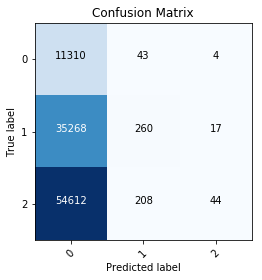

In [60]:
##############################
# Confusion Matrix of the Best Model
##############################
    
y_pred = cross_val_predict(best_clf, X, Y, cv=KFold(10))
conf_mat = confusion_matrix(Y, y_pred)
fig, ax = plt.subplots()
plot_confusion_matrix(conf_mat, classes=np.unique(Y), ax=ax, title='Confusion Matrix')

# Classifier Experiments

In [25]:
# tuned classifiers for testing

clf = DecisionTreeClassifier(criterion="entropy",
                             max_depth=10,
                             min_samples_split=0.1,
                             min_samples_leaf=1,
                             max_features='auto',
                             max_leaf_nodes=35,
                             class_weight={0:1, 1:10})

clfs = {
    'Decision Tree': DecisionTreeClassifier(criterion="entropy",
                             max_depth=10,
                             min_samples_split=0.1,
                             min_samples_leaf=1,
                             max_features='auto',
                             max_leaf_nodes=35),
    'kNN': KNeighborsClassifier(n_neighbors=1, p=5),
    'Gaussian Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(criterion="entropy",
                             max_depth=7,
                             min_samples_split=0.1,
                             min_samples_leaf=0.2,
                             max_features='auto',
                             n_estimators=8),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.5,
                             max_depth=16,
                             min_samples_split=0.4,
                             min_samples_leaf=0.03,
                             max_features='log2',
                             n_estimators=4),
    
    'SVM': SVC(C=0.1,
             degree=1,
             gamma=0.1,
             kernel='poly',
             probability=False)
}

In [29]:
##############################
# Pipeline Fit and Results
##############################

# 1. Feature Selection
feature_select = SelectKBest(k=5, score_func=f_classif)

# 2. Feature Transformation
feature_scale = StandardScaler(copy=True, with_mean=True, with_std=True)
feature_transform = PCA()

# 3. Select classifier
clf = clfs['Gradient Boosting']

exp_pipeline = Pipeline([
        ('feature_select', feature_select),
        ('feature_scale', feature_scale),
        ('feature_transform', feature_transform),
        ('clf', clf)
])

cv_results = cross_validate(exp_pipeline, X, Y,
                            cv=KFold(10), 
                            return_train_score=False,
                            scoring=scoring)

print("PARAMS:")
pp.pprint(exp_pipeline.get_params())

print("\nMODEL RESULTS:")
for k, v in cv_results.items():
    if "time" not in k:
        print("{0:22} {1:.3f} (+/-{2:.3f})".format(k, np.mean(v), np.std(v, ddof=1)))


PARAMS:
{   'clf': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=16,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.03, min_samples_split=0.4,
              min_weight_fraction_leaf=0.0, n_estimators=4,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
    'clf__criterion': 'friedman_mse',
    'clf__init': None,
    'clf__learning_rate': 0.5,
    'clf__loss': 'deviance',
    'clf__max_depth': 16,
    'clf__max_features': 'log2',
    'clf__max_leaf_nodes': None,
    'clf__min_impurity_decrease': 0.0,
    'clf__min_impurity_split': None,
    'clf__min_samples_leaf': 0.03,
    'clf__min_samples_split': 0.4,
    'clf__min_weight_fraction_leaf': 0.0,
    'clf__n_estimators': 4,


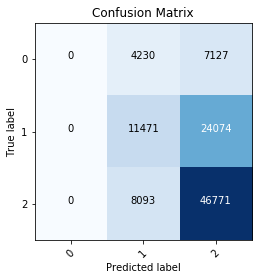

In [31]:
##############################
# Confusion Matrix on Pipeline
##############################
    
y_pred = cross_val_predict(exp_pipeline, X, Y, cv=KFold(10))
conf_mat = confusion_matrix(Y, y_pred)
fig, ax = plt.subplots()
plot_confusion_matrix(conf_mat, classes=np.unique(Y), ax=ax, title='Confusion Matrix')

In [ ]:
##############################
# Single Classifier Fit and Results
##############################

scoring = {'f1': 'f1_macro', 
           'recall': 'recall_macro',
           'precision': 'precision_macro',
#            'auc': 'roc_auc',
           'accuracy': 'accuracy',
#            'specificity': specificity
          }

use_clf = GradientBoostingClassifier()
cv_results = cross_validate(use_clf, X, Y,
                            cv=KFold(10), 
                            return_train_score=False,
                            scoring=scoring)

print("PARAMS:")
pp.pprint(use_clf.get_params())

print("\nMODEL RESULTS:")
for k, v in cv_results.items():
    if "time" not in k:
        print("{0:22} {1:.3f} (+/-{2:.3f})".format(k, np.mean(v), np.std(v, ddof=1)))


# Feature Selection Visualization

In [26]:
##############################
# Feature Selection Example: 
#        ANOVA
#        Mutual Information
##############################

# set base parameters
anova_params = {'score_func': f_classif, 'k': 10}
mi_params = {'score_func': mutual_info_classif, 'k': 10}

# select K best features
feature_select = SelectKBest()


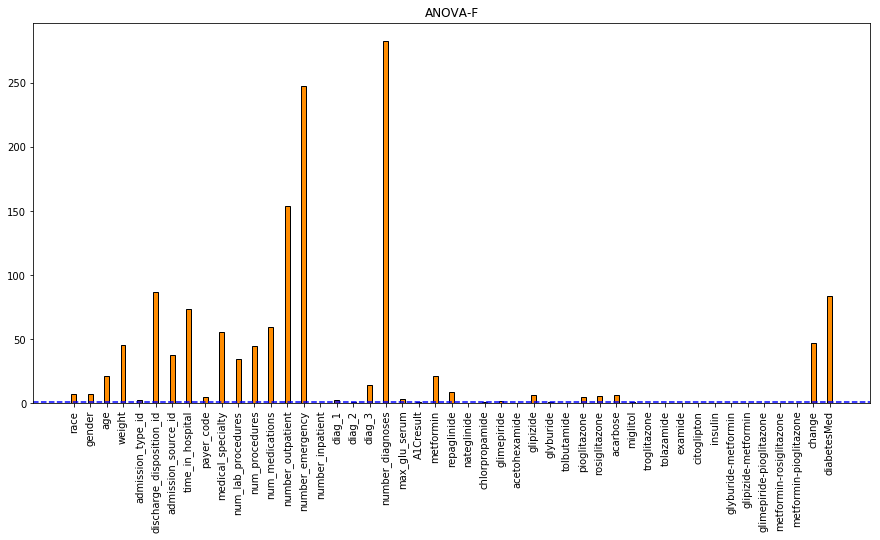

In [27]:
##############################
# Visualize Feature Scores
##############################

# anova feature score calculation
anova_select = feature_select.set_params(**anova_params)
anova_select.fit(X, Y)
scores = -np.log10(anova_select.pvalues_)
# scores /= np.max(scores)


# mi feature score calculation
mi_select = feature_select.set_params(**mi_params)
mi_select.fit(X, Y)
mi = mi_select.scores_
mi /= np.max(mi)


# visualize feature scores - anova
fig, ax = plt.subplots(figsize=(15, 7))
ind = np.arange(len(scores))

plt_anova = plt.bar(ind, scores, width=.3, color='darkorange', edgecolor='black')

ax.set_xticklabels(feature_names)
ax.axhline(-np.log10(0.05), ls='--', color='blue')
plt.xticks(ind, rotation=90)
plt.title('ANOVA-F')
plt.show()


# does not work well with this dataset
# visualize feature scores - mutual information
# fig, ax = plt.subplots(figsize=(15, 7))

# plt_mi = plt.bar(ind, mi, width=.3, color='lightgreen', edgecolor='black')

# ax.set_xticklabels(feature_names)
# plt.xticks(ind, rotation=90)
# plt.title('Mutual Information')
# plt.show()


# Feature Transformation Visualization

In [19]:
##############################
# Feature Transformation Example: 
#        Standard Scalar
#        PCA
#        NMF
#        Kernel PCA
##############################

# transform functions
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
pca = PCA()
nmf = NMF()
kpca = KernelPCA()


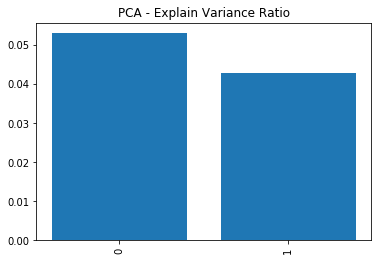

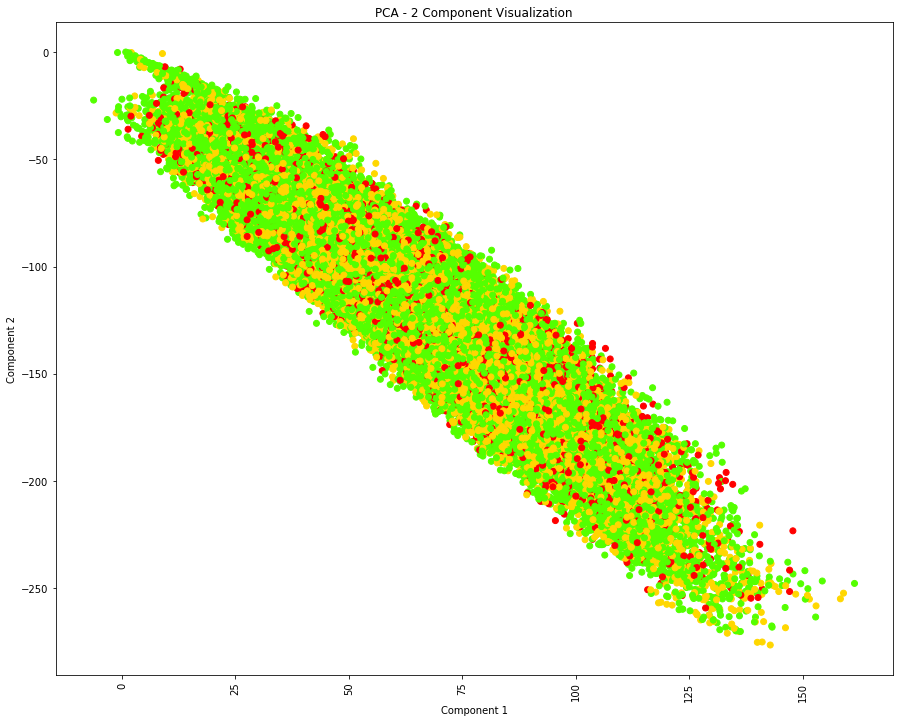

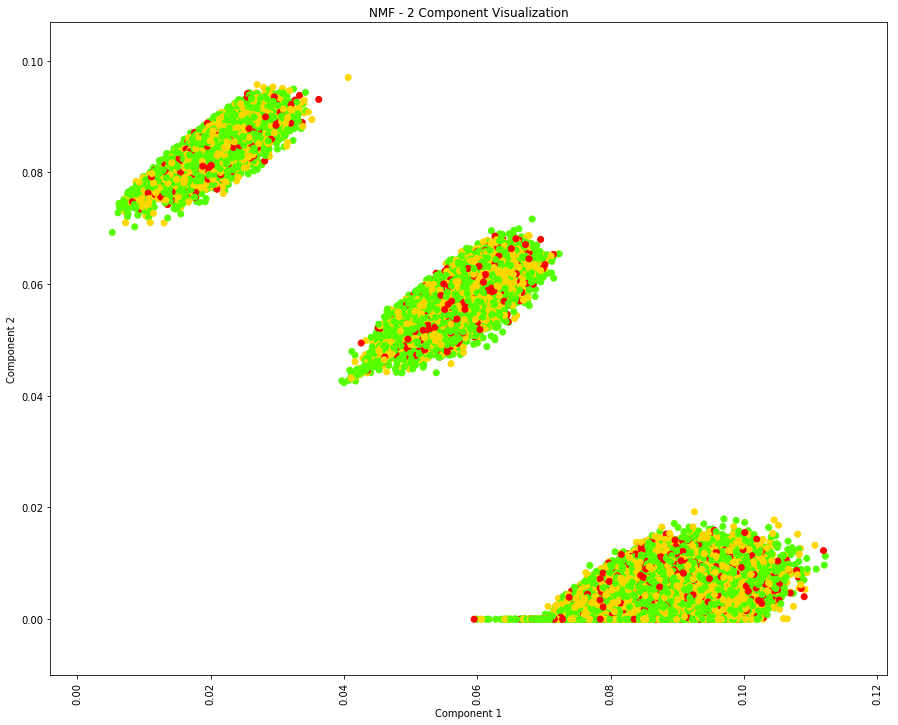

MemoryError: 

In [21]:
##############################
# Visualize Transformed Features
##############################

# set base parameters
pca_params = {'n_components': 2}
nmf_params = {'n_components': 2}
kpca_params = {
               'kernel': "rbf", 
               'gamma': 10,
               'degree': 3 # only for poly kernel
               }

# apply standard scaler to X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# display explained variance from PCA
pca.set_params(**pca_params)
pca.fit(X_scaled)
ind = np.arange(len(pca.explained_variance_ratio_))

plt.subplots()
plt.bar(ind, pca.explained_variance_ratio_)
plt.xticks(ind, rotation=90)
plt.title("PCA - Explain Variance Ratio")
plt.show()


# display results from PCA
pca_transformed = pca.transform(X)

plt.subplots(figsize=(15, 12))
plt.scatter(pca_transformed[:,0], pca_transformed[:,1], c=Y, cmap='prism', alpha=1)
plt.xticks(rotation=90)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA - 2 Component Visualization")
plt.show()


# apply minmax scaler to X
min_max_scaler = MinMaxScaler()
X_minmax_scaled = min_max_scaler.fit_transform(X)

# display results from NMF
nmf.set_params(**nmf_params)
nmf.fit(X_minmax_scaled)
nmf_transformed = nmf.transform(X_minmax_scaled)

plt.subplots(figsize=(15, 12))
plt.scatter(nmf_transformed[:,0], nmf_transformed[:,1], c=Y, cmap='prism', alpha=1)
plt.xticks(rotation=90)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("NMF - 2 Component Visualization")
plt.show()


# display results from KPCA
kpca_params = [{
               'kernel': "poly", 
               'gamma': 10,
               'degree': 3 # only for poly kernel
               },
               {
               'kernel': "poly", 
               'gamma': 10,
               'degree': 8 # only for poly kernel
               },
               {
               'kernel': "rbf", 
               'gamma': 10
               },
               {
               'kernel': "rbf", 
               'gamma': 50
               },
               {
               'kernel': "cosine"
               }]

for kpca_param in kpca_params:
    kpca.set_params(**kpca_param)
    kpca.fit(X_scaled)
    kpca_transformed = kpca.transform(X_scaled)

    plt.subplots(figsize=(15, 12))
    plt.scatter(kpca_transformed[:,0], kpca_transformed[:,1], c=Y, cmap='prism', alpha=1)
    plt.xticks(rotation=90)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("KPCA - Kernel: {}".format(kpca.get_params()['kernel']))
    plt.show()


# Exploratory Data Visualization

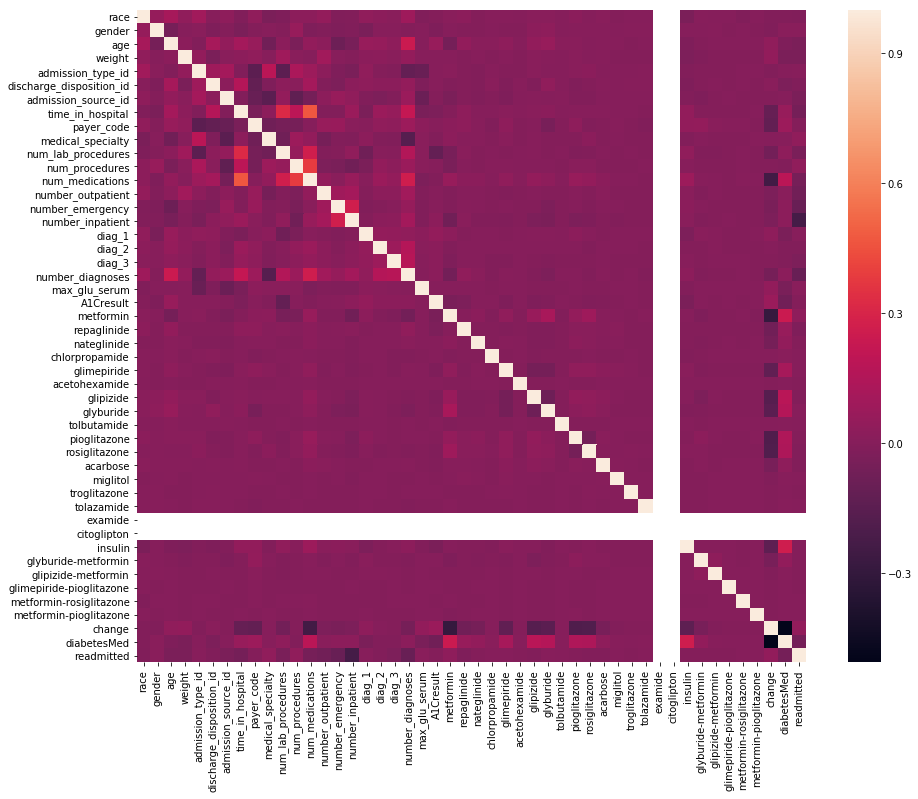

race                       -0.015184
gender                      0.014533
age                        -0.030271
weight                     -0.031107
admission_type_id           0.008950
discharge_disposition_id   -0.012450
admission_source_id        -0.031816
time_in_hospital           -0.057718
payer_code                 -0.005635
medical_specialty           0.040584
num_lab_procedures         -0.037976
num_procedures              0.038235
num_medications            -0.051772
number_outpatient          -0.068552
number_emergency           -0.103024
number_inpatient           -0.234283
diag_1                      0.010474
diag_2                     -0.006813
diag_3                     -0.024444
number_diagnoses           -0.104820
max_glu_serum               0.012554
A1Cresult                  -0.003312
metformin                   0.031149
repaglinide                -0.019256
nateglinide                -0.003039
chlorpropamide              0.001134
glimepiride                 0.001777
a

In [28]:
##############################
# Visualize Dataset Characteristics: 
#        Correlation Matrix
##############################

# calculate the correlation matrix
corr = use_dataframe.corr()

# plot the correlation heatmap
plt.subplots(figsize=(15, 12))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

print(corr['readmitted'])

# Clustering

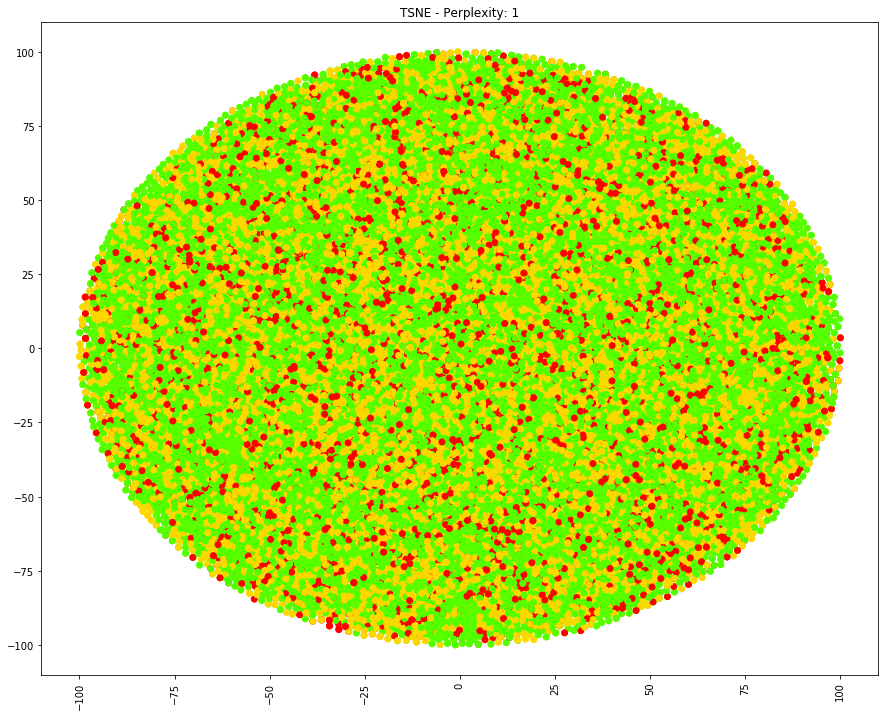

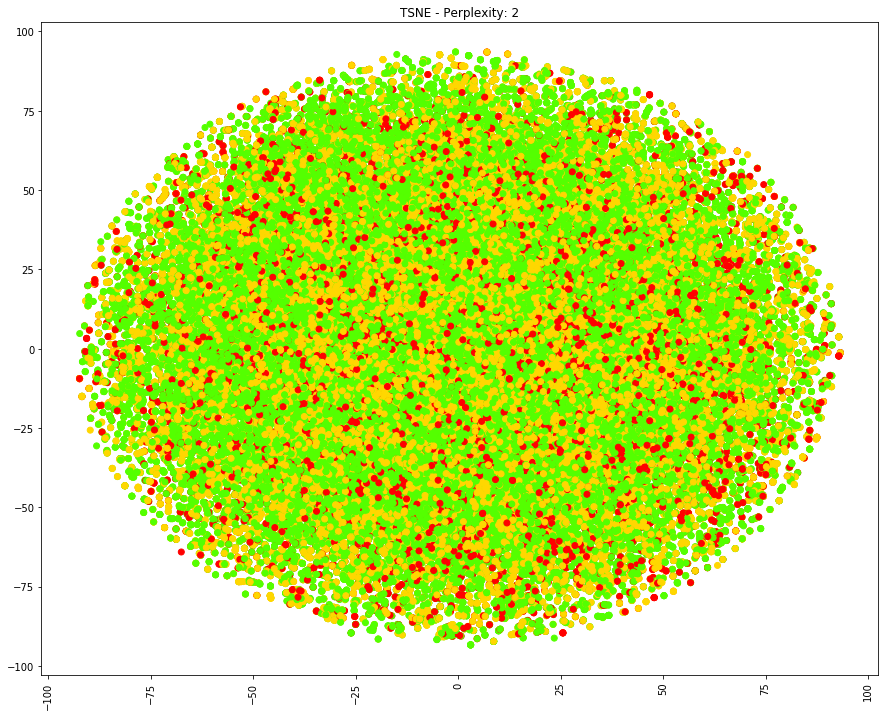

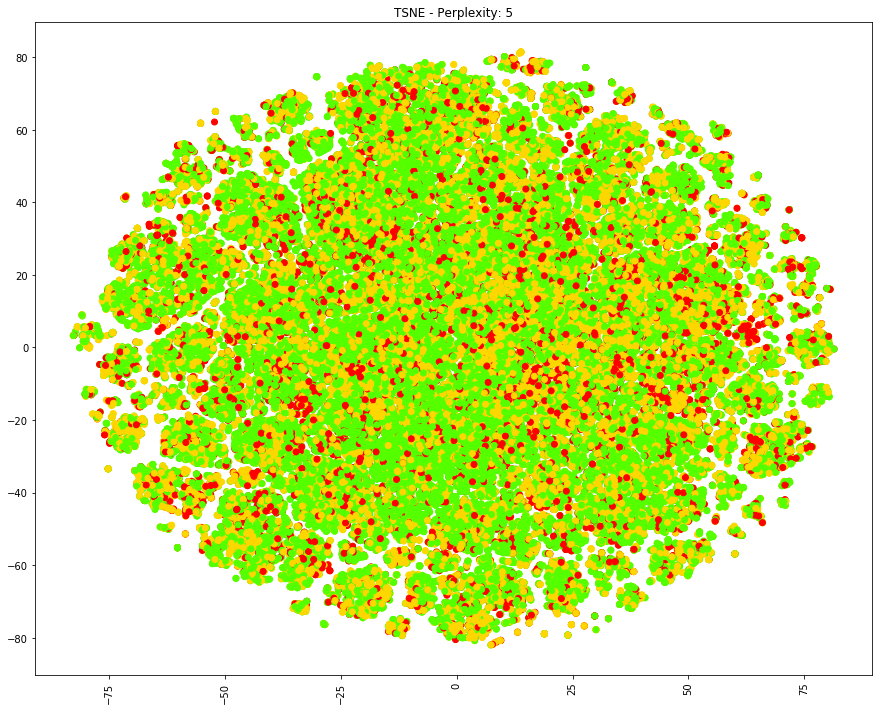

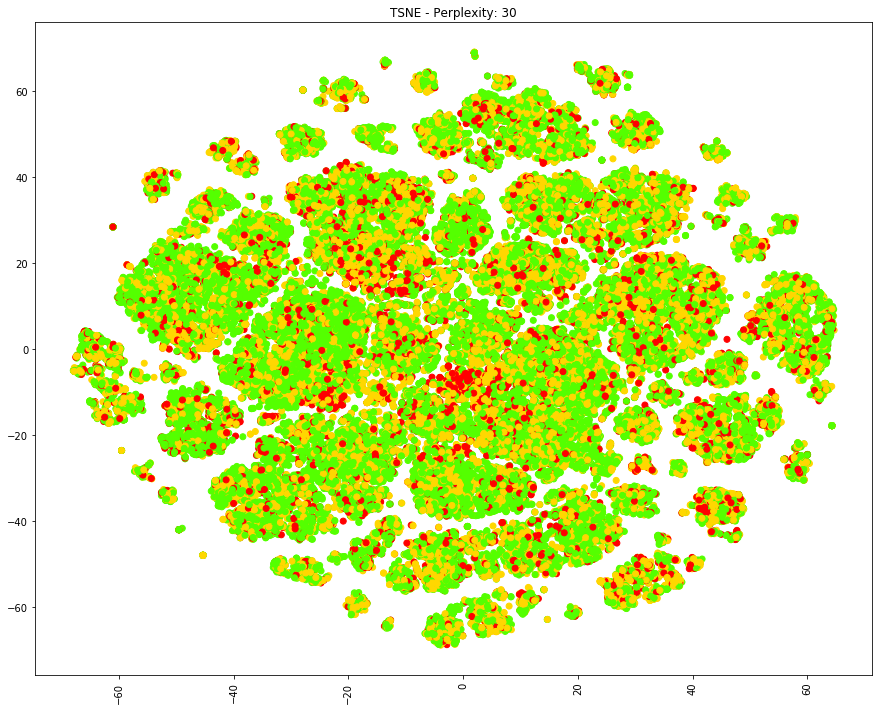

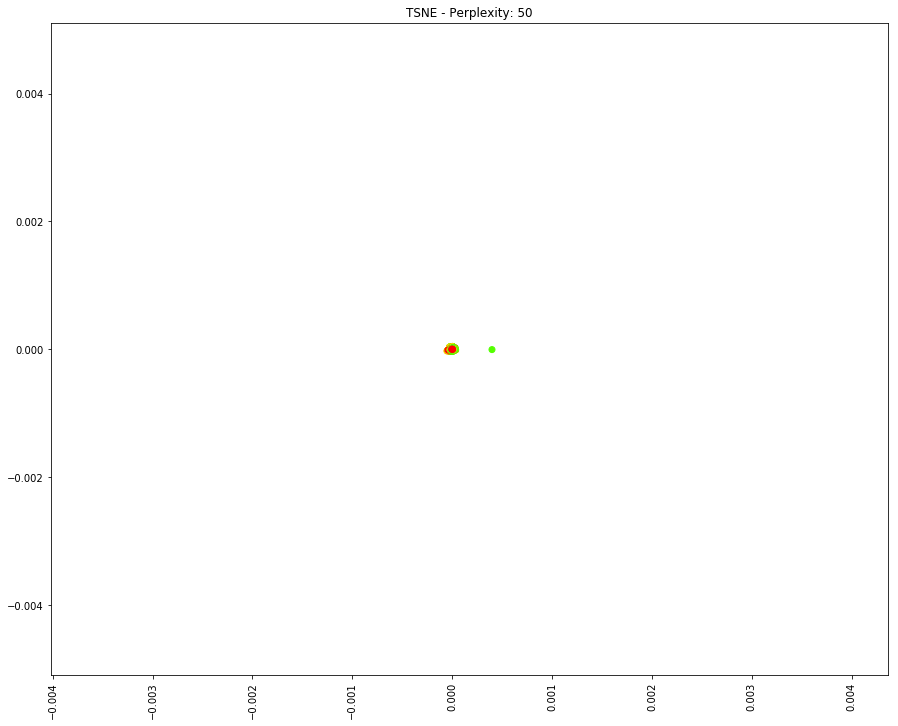

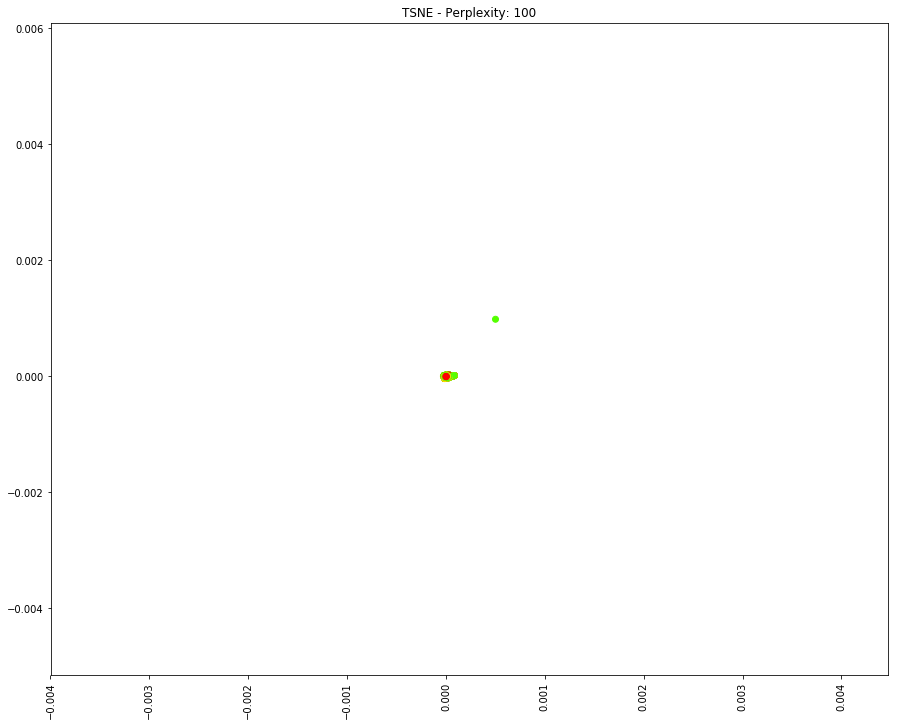

CPU times: user 1d 13h 47min 31s, sys: 6min 8s, total: 1d 13h 53min 39s
Wall time: 9h 12min 23s


In [30]:
%%time
##############################
# Clustering: 
#        tSNE
##############################

# iterate on perplexity
perplexity = [1, 2, 5, 30, 50, 100]

# apply standard scaler to X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for p in perplexity:
    # apply tSNE
    tsne = TSNE(n_components=2, perplexity=p, n_iter=5000, learning_rate=10)
    tsne_transformed = tsne.fit_transform(X_scaled)

    # display results from tSNE
    plt.subplots(figsize=(15, 12))
    plt.scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=Y, cmap='prism', alpha=1)
    plt.xticks(rotation=90)
    plt.title("TSNE - Perplexity: {}".format(tsne.get_params()['perplexity']))
    plt.show()


# Miscellaneous